In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('../datasets/BankChurners.csv')
list = ['Attrition_Flag', 'Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Contacts_Count_12_mon', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Months_on_book']
data = data[list]
#data = data.iloc[:,1:21]
np.random.seed(42)

In [9]:
object_columns = data.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(data[i])
    data[i] = lb.transform(data[i])
    
    print(f'category : {np.unique(data[i])}\nclasses : {lb.classes_}\n')

input = data.iloc[:,1:]
target = data.iloc[:,0]

category : [0 1]
classes : ['Attrited Customer' 'Existing Customer']



In [18]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)
y_train= to_categorical(y_train)
y_test= to_categorical(y_test)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8101, 8) (2026, 8) (8101, 2) (2026, 2)


In [38]:
import tensorflow as tf

def metric_precision(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 return precision

def metric_recall(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 recall=TP/(TP+FN)
 return recall

#F1-score    
def metric_F1score(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 recall=TP/(TP+FN)
 F1score=2*precision*recall/(precision+recall)
 return F1score

model = Sequential()

model.add(keras.Input(shape=(8,)))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score])
            
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 512)               4608      
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                     

In [39]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test Accuracy: %.4f' % (model.evaluate(x_test, y_test)[1]))


Epoch 1: val_loss improved from inf to 0.22836, saving model to ./model\01-0.228358.hdf5

Epoch 2: val_loss improved from 0.22836 to 0.19865, saving model to ./model\02-0.198648.hdf5

Epoch 3: val_loss improved from 0.19865 to 0.19354, saving model to ./model\03-0.193538.hdf5

Epoch 4: val_loss improved from 0.19354 to 0.18764, saving model to ./model\04-0.187641.hdf5

Epoch 5: val_loss improved from 0.18764 to 0.17971, saving model to ./model\05-0.179711.hdf5

Epoch 6: val_loss did not improve from 0.17971

Epoch 7: val_loss improved from 0.17971 to 0.17816, saving model to ./model\07-0.178156.hdf5

Epoch 8: val_loss improved from 0.17816 to 0.17769, saving model to ./model\08-0.177685.hdf5

Epoch 9: val_loss improved from 0.17769 to 0.17249, saving model to ./model\09-0.172493.hdf5

Epoch 10: val_loss improved from 0.17249 to 0.17073, saving model to ./model\10-0.170729.hdf5

Epoch 11: val_loss improved from 0.17073 to 0.16966, saving model to ./model\11-0.169658.hdf5

Epoch 12: val

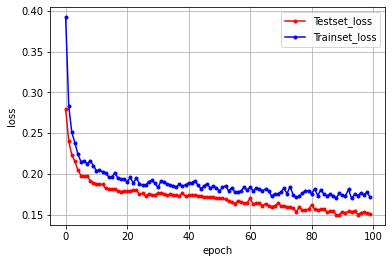

In [35]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [58]:
import tensorflow as tf

def metric_precision(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 return precision

def metric_recall(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 recall=TP/(TP+FN)
 return recall

#F1-score    
def metric_F1score(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 recall=TP/(TP+FN)
 F1score=2*precision*recall/(precision+recall)
 return F1score

model = Sequential()

model.add(keras.Input(shape=(8,)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score])
            
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_13 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dense_49 (Dense)            (None, 256)               2304      
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 64)                8256      
                                                     

In [59]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test Accuracy: %.4f' % (model.evaluate(x_test, y_test)[1]))


Epoch 1: val_loss improved from inf to 0.23693, saving model to ./model\01-0.236932.hdf5

Epoch 2: val_loss improved from 0.23693 to 0.20405, saving model to ./model\02-0.204049.hdf5

Epoch 3: val_loss improved from 0.20405 to 0.19249, saving model to ./model\03-0.192488.hdf5

Epoch 4: val_loss improved from 0.19249 to 0.18656, saving model to ./model\04-0.186556.hdf5

Epoch 5: val_loss improved from 0.18656 to 0.18376, saving model to ./model\05-0.183759.hdf5

Epoch 6: val_loss improved from 0.18376 to 0.18035, saving model to ./model\06-0.180352.hdf5

Epoch 7: val_loss did not improve from 0.18035

Epoch 8: val_loss did not improve from 0.18035

Epoch 9: val_loss did not improve from 0.18035

Epoch 10: val_loss did not improve from 0.18035

Epoch 11: val_loss improved from 0.18035 to 0.17362, saving model to ./model\11-0.173623.hdf5

Epoch 12: val_loss did not improve from 0.17362

Epoch 13: val_loss improved from 0.17362 to 0.16974, saving model to ./model\13-0.169742.hdf5

Epoch 1